# ARIMA and SARIMA Models for Time Series Forecasting

**Course:** Crash Course in Forecasting  
**Topic:** Autoregressive Integrated Moving Average Models  
**Author:** Data Science Education  
**Date:** November 2025

## Abstract

This notebook provides a comprehensive introduction to ARIMA (Autoregressive Integrated Moving Average) and SARIMA (Seasonal ARIMA) models, two of the most widely used statistical methods for time series forecasting. These models are powerful tools that can capture different aspects of temporal patterns including trends, seasonality, and autocorrelation.

**Key Learning Objectives:**
- Understand the components of ARIMA models: AR, I, and MA
- Learn how to assess stationarity and transform non-stationary series
- Master the identification of model parameters (p, d, q) using ACF and PACF plots
- Implement ARIMA and SARIMA models using Python's statsmodels library
- Evaluate model performance and make accurate forecasts
- Apply SARIMA models to capture seasonal patterns in data
- Understand model diagnostics and residual analysis

By the end of this chapter, you will be able to build, validate, and deploy ARIMA/SARIMA models for real-world forecasting applications, understanding when these classical methods are appropriate and how to optimize their performance.

## 1. Theory: Understanding ARIMA and SARIMA Models

### 1.1 What is ARIMA?

ARIMA stands for **Autoregressive Integrated Moving Average**. It's a generalization that combines three components:

**1. AR (Autoregressive) - p parameter**
- Uses past values to predict future values
- AR(p) model: $y_t = c + \phi_1 y_{t-1} + \phi_2 y_{t-2} + ... + \phi_p y_{t-p} + \epsilon_t$
- The value depends on p previous observations

**2. I (Integrated) - d parameter**
- Number of differencing operations needed to make the series stationary
- First difference: $y'_t = y_t - y_{t-1}$
- Second difference: $y''_t = y'_t - y'_{t-1}$
- Removes trends and makes variance constant

**3. MA (Moving Average) - q parameter**
- Uses past forecast errors in a regression-like model
- MA(q) model: $y_t = c + \epsilon_t + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q}$
- The value depends on q previous error terms

**Complete ARIMA(p,d,q) Model:**
$$y'_t = c + \phi_1 y'_{t-1} + ... + \phi_p y'_{t-p} + \theta_1 \epsilon_{t-1} + ... + \theta_q \epsilon_{t-q} + \epsilon_t$$

where $y'_t$ is the differenced series (d times).

### 1.2 Stationarity: A Key Requirement

**Why Stationarity Matters:**
- ARIMA models require the time series to be stationary (after differencing)
- A stationary series has constant mean, variance, and autocorrelation over time
- Non-stationary series have trends, changing variance, or seasonal patterns

**Testing for Stationarity:**
- **Visual inspection**: Plot the series and look for trends
- **Augmented Dickey-Fuller (ADF) test**: Statistical test (p-value < 0.05 suggests stationarity)
- **KPSS test**: Null hypothesis is that series is stationary

**Achieving Stationarity:**
- Differencing (most common)
- Log transformation (stabilizes variance)
- Detrending (remove linear trend)

### 1.3 Identifying Model Parameters

**ACF (Autocorrelation Function):**
- Measures correlation between observations at different lags
- Helps identify the MA order (q)
- Sharp cutoff at lag q suggests MA(q)

**PACF (Partial Autocorrelation Function):**
- Measures correlation after removing effects of intermediate lags
- Helps identify the AR order (p)
- Sharp cutoff at lag p suggests AR(p)

**Rule of Thumb:**
- ACF cuts off at lag q → MA(q) model
- PACF cuts off at lag p → AR(p) model
- Both tail off gradually → ARMA(p,q) model

### 1.4 SARIMA: Adding Seasonality

**SARIMA(p,d,q)(P,D,Q)m** extends ARIMA to handle seasonal patterns:
- **(p,d,q)**: Non-seasonal parameters
- **(P,D,Q)**: Seasonal parameters
- **m**: Number of periods in a season (e.g., 12 for monthly data with yearly seasonality)

**Seasonal Components:**
- **P**: Seasonal AR order
- **D**: Seasonal differencing order
- **Q**: Seasonal MA order

Example: SARIMA(1,1,1)(1,1,1)12 for monthly data with yearly seasonality

### 1.5 Model Selection Criteria

**AIC (Akaike Information Criterion):**
- Lower is better
- Penalizes model complexity
- Formula: $AIC = -2\ln(L) + 2k$ (L = likelihood, k = parameters)

**BIC (Bayesian Information Criterion):**
- Lower is better
- Penalizes complexity more heavily than AIC
- Formula: $BIC = -2\ln(L) + k\ln(n)$ (n = sample size)

**RMSE/MAE:**
- Root Mean Squared Error / Mean Absolute Error
- Measures prediction accuracy on test set

In [1]:
# Import required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from statsmodels.tsa.stattools import adfuller, kpss, acf, pacf
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.tsa.statespace.sarimax import SARIMAX
from sklearn.metrics import mean_squared_error, mean_absolute_error
from scipy import stats
import warnings
warnings.filterwarnings('ignore')

# Set visualization parameters
plt.style.use('seaborn-v0_8-darkgrid')
sns.set_palette("husl")
plt.rcParams['figure.figsize'] = (12, 6)

print("✓ Libraries imported successfully!")
print(f"Pandas version: {pd.__version__}")
print(f"NumPy version: {np.__version__}")

✓ Libraries imported successfully!
Pandas version: 2.2.3
NumPy version: 2.1.3


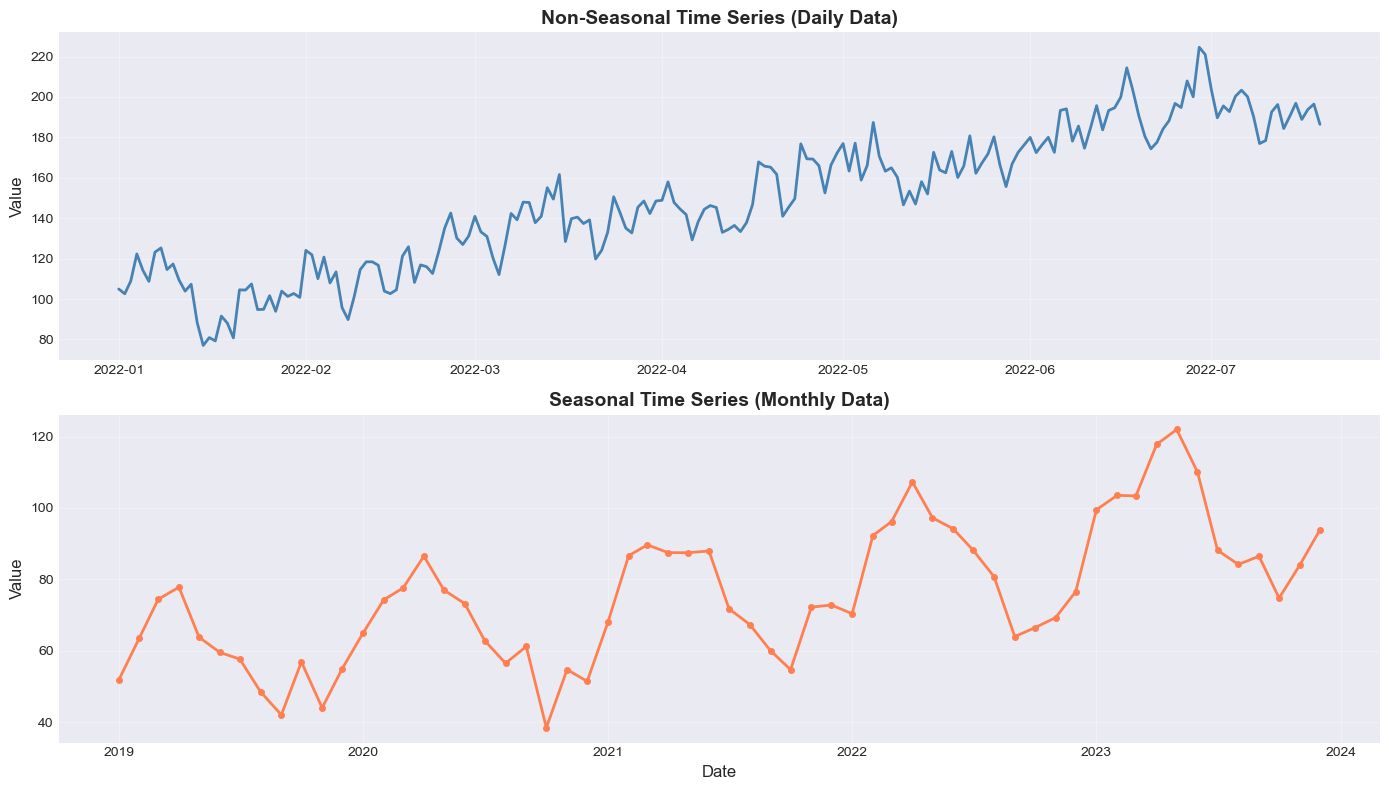

Non-seasonal series shape: (200, 1)
Seasonal series shape: (60, 1)


In [2]:
# Set random seed for reproducibility
np.random.seed(42)

# Dataset 1: Non-seasonal data (website traffic)
n_points = 200
dates = pd.date_range(start='2022-01-01', periods=n_points, freq='D')

# Generate AR(1) process with trend
trend = np.linspace(100, 200, n_points)
ar_component = np.zeros(n_points)
ar_component[0] = np.random.normal(0, 10)
for t in range(1, n_points):
    ar_component[t] = 0.7 * ar_component[t-1] + np.random.normal(0, 10)

non_seasonal_series = trend + ar_component

df_non_seasonal = pd.DataFrame({
    'date': dates,
    'value': non_seasonal_series
})
df_non_seasonal.set_index('date', inplace=True)

# Dataset 2: Seasonal data (monthly sales)
n_months = 60  # 5 years
dates_monthly = pd.date_range(start='2019-01-01', periods=n_months, freq='MS')

# Generate data with trend and seasonality
monthly_trend = np.linspace(50, 100, n_months)
seasonal_pattern = 20 * np.sin(2 * np.pi * np.arange(n_months) / 12)
noise = np.random.normal(0, 5, n_months)

seasonal_series = monthly_trend + seasonal_pattern + noise

df_seasonal = pd.DataFrame({
    'date': dates_monthly,
    'value': seasonal_series
})
df_seasonal.set_index('date', inplace=True)

# Visualize both series
fig, axes = plt.subplots(2, 1, figsize=(14, 8))

axes[0].plot(df_non_seasonal.index, df_non_seasonal['value'], 
             linewidth=2, color='steelblue')
axes[0].set_title('Non-Seasonal Time Series (Daily Data)', 
                  fontsize=14, fontweight='bold')
axes[0].set_ylabel('Value', fontsize=12)
axes[0].grid(True, alpha=0.3)

axes[1].plot(df_seasonal.index, df_seasonal['value'], 
             linewidth=2, color='coral', marker='o', markersize=4)
axes[1].set_title('Seasonal Time Series (Monthly Data)', 
                  fontsize=14, fontweight='bold')
axes[1].set_ylabel('Value', fontsize=12)
axes[1].set_xlabel('Date', fontsize=12)
axes[1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

print(f"Non-seasonal series shape: {df_non_seasonal.shape}")
print(f"Seasonal series shape: {df_seasonal.shape}")

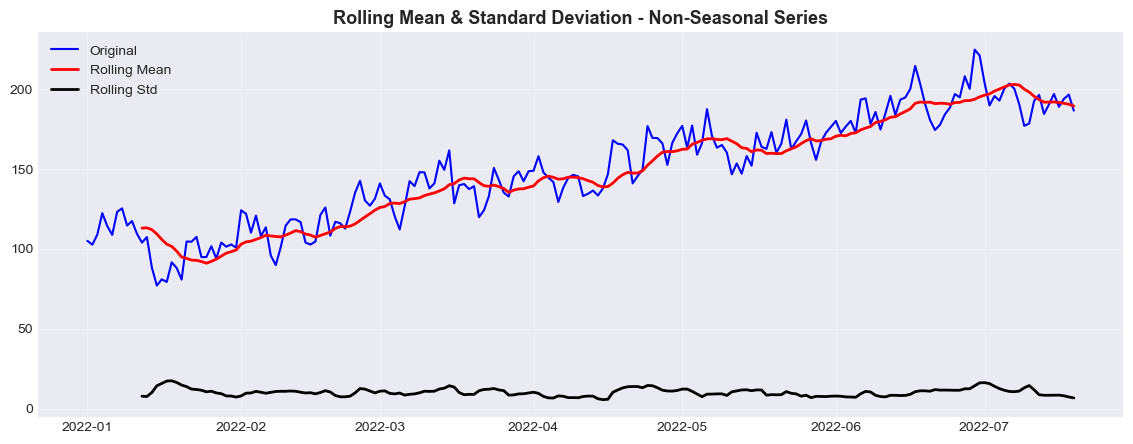


Augmented Dickey-Fuller Test Results - Non-Seasonal Series
ADF Statistic: -0.985785
p-value: 0.758414
Number of lags used: 4
Number of observations: 195

Critical Values:
   1%: -3.464
   5%: -2.876
   10%: -2.575

✗ CONCLUSION: Series is NON-STATIONARY (p-value = 0.758414 > 0.05)
   We cannot reject the null hypothesis. Differencing is needed.



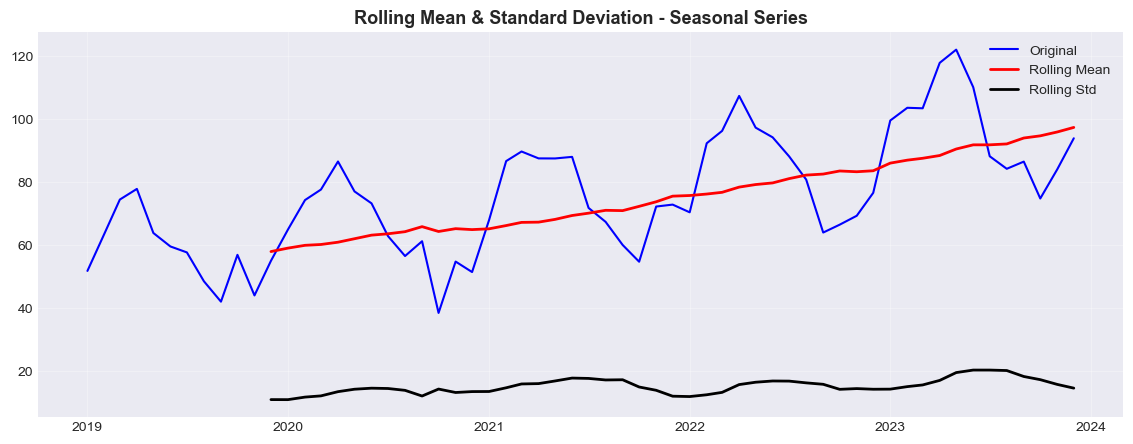


Augmented Dickey-Fuller Test Results - Seasonal Series
ADF Statistic: 1.346696
p-value: 0.996858
Number of lags used: 10
Number of observations: 49

Critical Values:
   1%: -3.571
   5%: -2.923
   10%: -2.599

✗ CONCLUSION: Series is NON-STATIONARY (p-value = 0.996858 > 0.05)
   We cannot reject the null hypothesis. Differencing is needed.



In [3]:
def test_stationarity(timeseries, title='Time Series'):
    """
    Perform Augmented Dickey-Fuller test and visualize rolling statistics.
    
    Parameters:
    -----------
    timeseries : pandas Series
        Time series data to test
    title : str
        Title for the plots
    """
    # Calculate rolling statistics
    rolmean = timeseries.rolling(window=12).mean()
    rolstd = timeseries.rolling(window=12).std()
    
    # Plot rolling statistics
    fig, ax = plt.subplots(figsize=(14, 5))
    ax.plot(timeseries, color='blue', label='Original', linewidth=1.5)
    ax.plot(rolmean, color='red', label='Rolling Mean', linewidth=2)
    ax.plot(rolstd, color='black', label='Rolling Std', linewidth=2)
    ax.legend(loc='best')
    ax.set_title(f'Rolling Mean & Standard Deviation - {title}', 
                 fontsize=13, fontweight='bold')
    ax.grid(True, alpha=0.3)
    plt.show()
    
    # Perform Augmented Dickey-Fuller test
    print(f'\n{"="*60}')
    print(f'Augmented Dickey-Fuller Test Results - {title}')
    print(f'{"="*60}')
    
    adf_result = adfuller(timeseries, autolag='AIC')
    
    print(f'ADF Statistic: {adf_result[0]:.6f}')
    print(f'p-value: {adf_result[1]:.6f}')
    print(f'Number of lags used: {adf_result[2]}')
    print(f'Number of observations: {adf_result[3]}')
    print(f'\nCritical Values:')
    for key, value in adf_result[4].items():
        print(f'   {key}: {value:.3f}')
    
    # Interpretation
    if adf_result[1] <= 0.05:
        print(f'\n✓ CONCLUSION: Series is STATIONARY (p-value = {adf_result[1]:.6f} < 0.05)')
        print('   We can reject the null hypothesis of non-stationarity.')
    else:
        print(f'\n✗ CONCLUSION: Series is NON-STATIONARY (p-value = {adf_result[1]:.6f} > 0.05)')
        print('   We cannot reject the null hypothesis. Differencing is needed.')
    print(f'{"="*60}\n')

# Test both series
test_stationarity(df_non_seasonal['value'], 'Non-Seasonal Series')
test_stationarity(df_seasonal['value'], 'Seasonal Series')

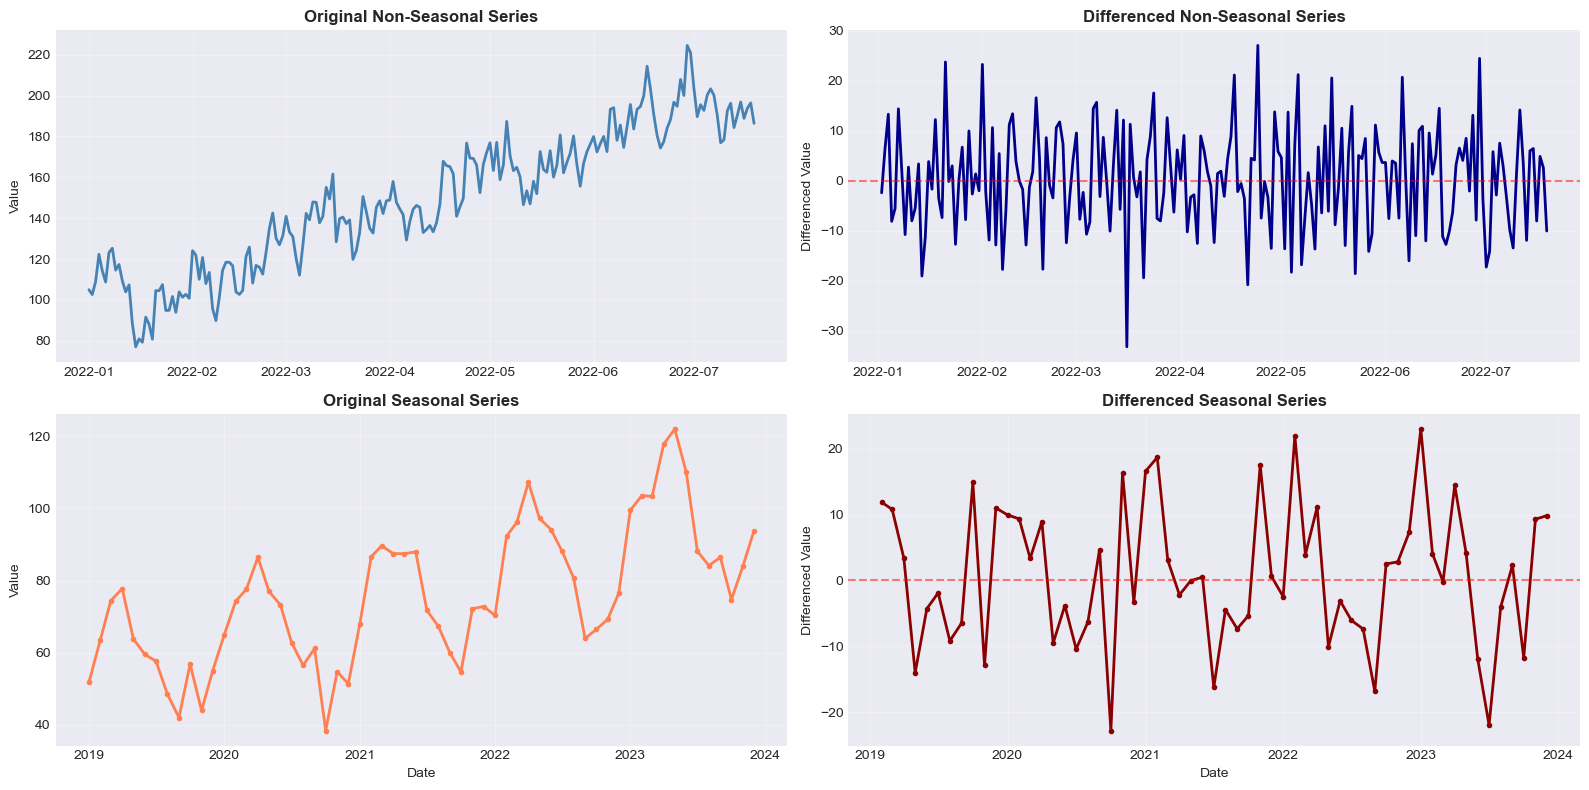

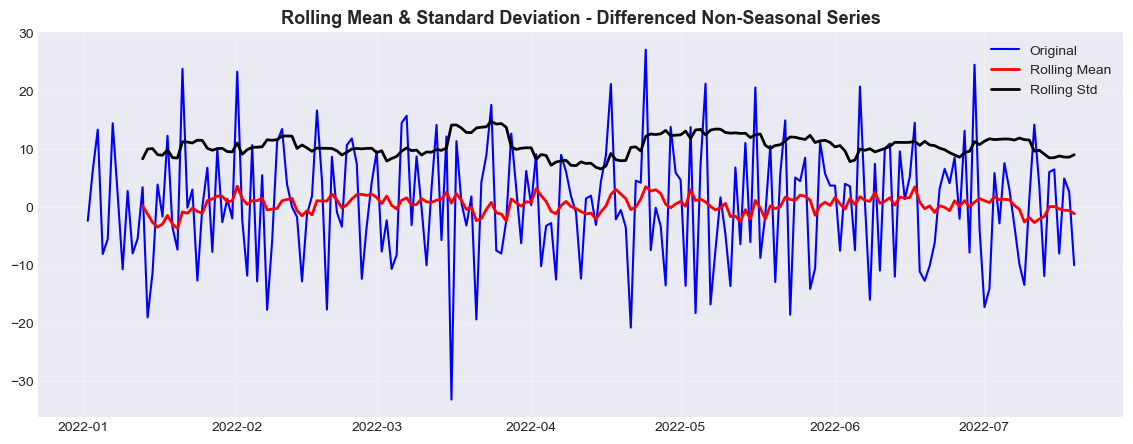


Augmented Dickey-Fuller Test Results - Differenced Non-Seasonal Series
ADF Statistic: -10.750203
p-value: 0.000000
Number of lags used: 3
Number of observations: 195

Critical Values:
   1%: -3.464
   5%: -2.876
   10%: -2.575

✓ CONCLUSION: Series is STATIONARY (p-value = 0.000000 < 0.05)
   We can reject the null hypothesis of non-stationarity.



In [4]:
# Apply first-order differencing
df_non_seasonal_diff = df_non_seasonal['value'].diff().dropna()
df_seasonal_diff = df_seasonal['value'].diff().dropna()

# Visualize the differenced series
fig, axes = plt.subplots(2, 2, figsize=(16, 8))

# Original non-seasonal
axes[0, 0].plot(df_non_seasonal.index, df_non_seasonal['value'], 
                linewidth=2, color='steelblue')
axes[0, 0].set_title('Original Non-Seasonal Series', fontsize=12, fontweight='bold')
axes[0, 0].set_ylabel('Value')
axes[0, 0].grid(True, alpha=0.3)

# Differenced non-seasonal
axes[0, 1].plot(df_non_seasonal_diff.index, df_non_seasonal_diff, 
                linewidth=2, color='darkblue')
axes[0, 1].set_title('Differenced Non-Seasonal Series', fontsize=12, fontweight='bold')
axes[0, 1].set_ylabel('Differenced Value')
axes[0, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[0, 1].grid(True, alpha=0.3)

# Original seasonal
axes[1, 0].plot(df_seasonal.index, df_seasonal['value'], 
                linewidth=2, color='coral', marker='o', markersize=3)
axes[1, 0].set_title('Original Seasonal Series', fontsize=12, fontweight='bold')
axes[1, 0].set_ylabel('Value')
axes[1, 0].set_xlabel('Date')
axes[1, 0].grid(True, alpha=0.3)

# Differenced seasonal
axes[1, 1].plot(df_seasonal_diff.index, df_seasonal_diff, 
                linewidth=2, color='darkred', marker='o', markersize=3)
axes[1, 1].set_title('Differenced Seasonal Series', fontsize=12, fontweight='bold')
axes[1, 1].set_ylabel('Differenced Value')
axes[1, 1].set_xlabel('Date')
axes[1, 1].axhline(y=0, color='r', linestyle='--', alpha=0.5)
axes[1, 1].grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

# Test stationarity of differenced series
test_stationarity(df_non_seasonal_diff, 'Differenced Non-Seasonal Series')

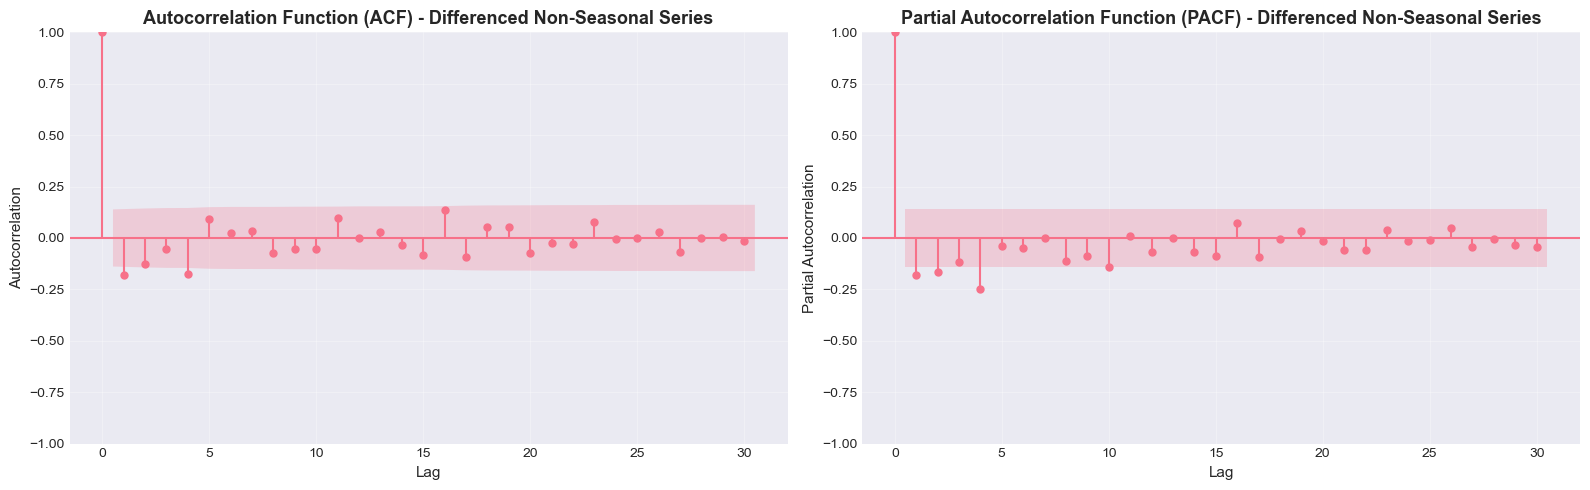


Interpretation Guide for Differenced Non-Seasonal Series:
------------------------------------------------------------
ACF: Identifies MA(q) order
  - Sharp cutoff at lag q → suggests MA(q)
  - Gradual decline → suggests AR component

PACF: Identifies AR(p) order
  - Sharp cutoff at lag p → suggests AR(p)
  - Gradual decline → suggests MA component
------------------------------------------------------------


In [5]:
def plot_acf_pacf(series, title='Series', lags=40):
    """
    Plot ACF and PACF for a given series.
    
    Parameters:
    -----------
    series : pandas Series
        Time series data
    title : str
        Title for the plots
    lags : int
        Number of lags to display
    """
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # ACF plot
    plot_acf(series, lags=lags, ax=axes[0], alpha=0.05)
    axes[0].set_title(f'Autocorrelation Function (ACF) - {title}', 
                      fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Lag', fontsize=11)
    axes[0].set_ylabel('Autocorrelation', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # PACF plot
    plot_pacf(series, lags=lags, ax=axes[1], alpha=0.05, method='ywm')
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {title}', 
                      fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Lag', fontsize=11)
    axes[1].set_ylabel('Partial Autocorrelation', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f'\nInterpretation Guide for {title}:')
    print('-' * 60)
    print('ACF: Identifies MA(q) order')
    print('  - Sharp cutoff at lag q → suggests MA(q)')
    print('  - Gradual decline → suggests AR component')
    print('\nPACF: Identifies AR(p) order')
    print('  - Sharp cutoff at lag p → suggests AR(p)')
    print('  - Gradual decline → suggests MA component')
    print('-' * 60)

# Plot for differenced non-seasonal series
plot_acf_pacf(df_non_seasonal_diff, 'Differenced Non-Seasonal Series', lags=30)

In [6]:
# Split data into train and test sets (80-20 split)
train_size = int(len(df_non_seasonal) * 0.8)
train = df_non_seasonal[:train_size]
test = df_non_seasonal[train_size:]

print(f"Training set size: {len(train)}")
print(f"Test set size: {len(test)}")
print(f"Train period: {train.index.min()} to {train.index.max()}")
print(f"Test period: {test.index.min()} to {test.index.max()}")

# Build ARIMA model
# Based on ACF/PACF, let's try ARIMA(2,1,2)
print("\n" + "="*60)
print("Building ARIMA(2,1,2) Model")
print("="*60)

model_arima = ARIMA(train['value'], order=(2, 1, 2))
fitted_model = model_arima.fit()

# Print model summary
print(fitted_model.summary())

Training set size: 160
Test set size: 40
Train period: 2022-01-01 00:00:00 to 2022-06-09 00:00:00
Test period: 2022-06-10 00:00:00 to 2022-07-19 00:00:00

Building ARIMA(2,1,2) Model
                               SARIMAX Results                                
Dep. Variable:                  value   No. Observations:                  160
Model:                 ARIMA(2, 1, 2)   Log Likelihood                -585.031
Date:                Thu, 20 Nov 2025   AIC                           1180.062
Time:                        21:52:53   BIC                           1195.406
Sample:                    01-01-2022   HQIC                          1186.293
                         - 06-09-2022                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1         -0.3779      


Forecast Performance Metrics
Mean Squared Error (MSE):       257.9435
Root Mean Squared Error (RMSE): 16.0606
Mean Absolute Error (MAE):      13.0205
Mean Absolute % Error (MAPE):   6.50%


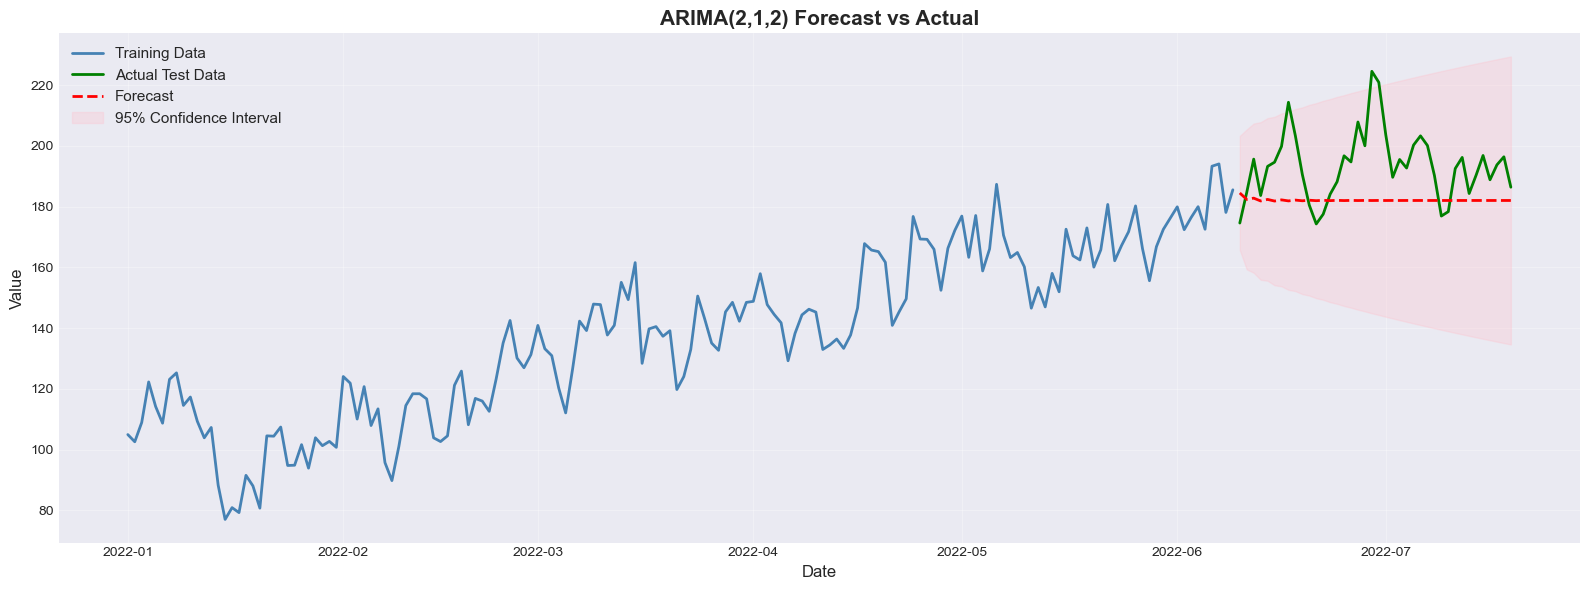

In [7]:
# Make predictions on test set
forecast_steps = len(test)
forecast = fitted_model.forecast(steps=forecast_steps)

# Get confidence intervals
forecast_result = fitted_model.get_forecast(steps=forecast_steps)
forecast_ci = forecast_result.conf_int()

# Calculate errors
mse = mean_squared_error(test['value'], forecast)
rmse = np.sqrt(mse)
mae = mean_absolute_error(test['value'], forecast)
mape = np.mean(np.abs((test['value'] - forecast) / test['value'])) * 100

print("\n" + "="*60)
print("Forecast Performance Metrics")
print("="*60)
print(f"Mean Squared Error (MSE):       {mse:.4f}")
print(f"Root Mean Squared Error (RMSE): {rmse:.4f}")
print(f"Mean Absolute Error (MAE):      {mae:.4f}")
print(f"Mean Absolute % Error (MAPE):   {mape:.2f}%")
print("="*60)

# Visualize predictions
fig, ax = plt.subplots(figsize=(16, 6))

# Plot training data
ax.plot(train.index, train['value'], label='Training Data', 
        linewidth=2, color='steelblue')

# Plot test data
ax.plot(test.index, test['value'], label='Actual Test Data', 
        linewidth=2, color='green')

# Plot forecast
ax.plot(test.index, forecast, label='Forecast', 
        linewidth=2, color='red', linestyle='--')

# Plot confidence intervals
ax.fill_between(test.index, 
                forecast_ci.iloc[:, 0], 
                forecast_ci.iloc[:, 1], 
                color='pink', alpha=0.3, label='95% Confidence Interval')

ax.set_title('ARIMA(2,1,2) Forecast vs Actual', fontsize=15, fontweight='bold')
ax.set_xlabel('Date', fontsize=12)
ax.set_ylabel('Value', fontsize=12)
ax.legend(loc='best', fontsize=11)
ax.grid(True, alpha=0.3)

plt.tight_layout()
plt.show()

In [8]:
# Grid search for best ARIMA parameters
def find_best_arima(data, p_range=range(0, 4), d_range=range(0, 3), q_range=range(0, 4)):
    """
    Find best ARIMA parameters using grid search on AIC.
    
    Parameters:
    -----------
    data : pandas Series
        Time series data
    p_range, d_range, q_range : range objects
        Ranges for AR, I, and MA orders
    
    Returns:
    --------
    tuple : (best_order, best_aic, results_df)
    """
    best_aic = np.inf
    best_order = None
    results = []
    
    print("Searching for best ARIMA parameters...\n")
    
    for p in p_range:
        for d in d_range:
            for q in q_range:
                try:
                    model = ARIMA(data, order=(p, d, q))
                    fitted = model.fit()
                    aic = fitted.aic
                    results.append({
                        'p': p, 'd': d, 'q': q,
                        'AIC': aic,
                        'BIC': fitted.bic
                    })
                    
                    if aic < best_aic:
                        best_aic = aic
                        best_order = (p, d, q)
                except:
                    continue
    
    results_df = pd.DataFrame(results).sort_values('AIC')
    return best_order, best_aic, results_df

# Find best parameters
best_order, best_aic, results_df = find_best_arima(train['value'])

print("="*60)
print(f"Best ARIMA Order: {best_order}")
print(f"Best AIC: {best_aic:.4f}")
print("="*60)
print("\nTop 10 Model Configurations:")
print(results_df.head(10))

Searching for best ARIMA parameters...

Best ARIMA Order: (1, 1, 1)
Best AIC: 1179.0134

Top 10 Model Configurations:
    p  d  q          AIC          BIC
17  1  1  1  1179.013377  1188.220089
43  3  1  3  1179.617331  1201.099661
30  2  1  2  1180.061526  1195.406047
35  2  2  3  1180.124301  1198.499871
6   0  1  2  1180.611056  1189.817769
11  0  2  3  1180.718203  1192.968583
29  2  1  1  1180.871397  1193.147014
18  1  1  2  1180.877203  1193.152820
7   0  1  3  1181.593028  1193.868645
42  3  1  2  1181.864302  1200.277727


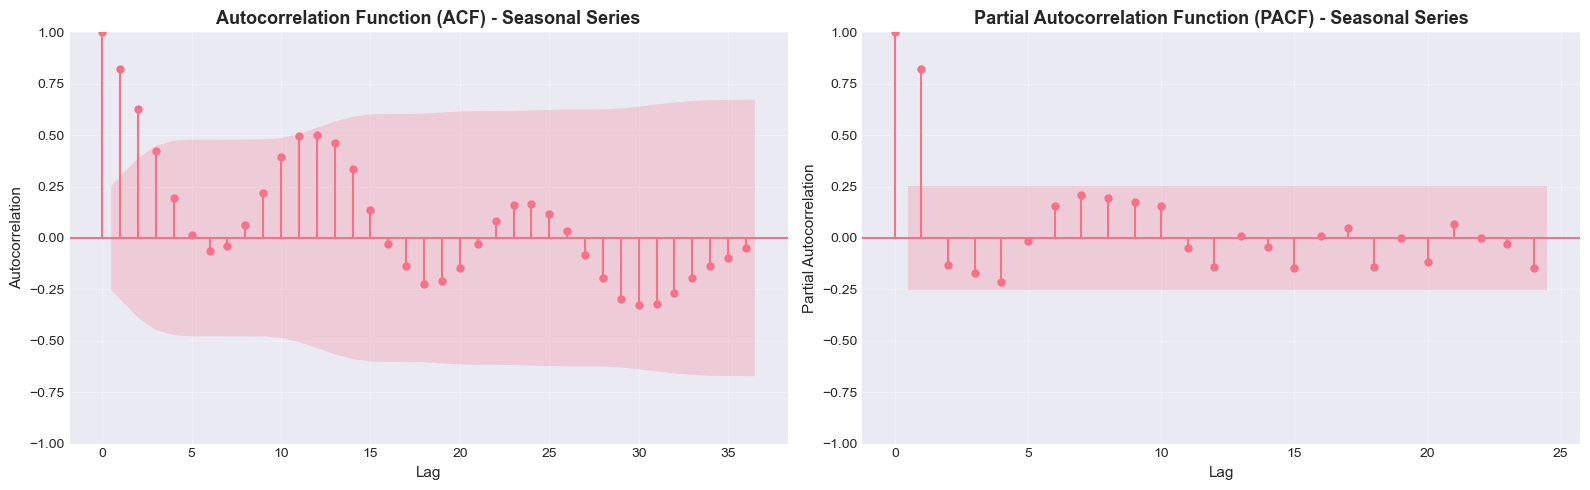


Interpretation Guide for Seasonal Series:
------------------------------------------------------------
ACF: Identifies MA(q) order
  - Sharp cutoff at lag q → suggests MA(q)
  - Gradual decline → suggests AR component

PACF: Identifies AR(p) order
  - Sharp cutoff at lag p → suggests AR(p)
  - Gradual decline → suggests MA component
------------------------------------------------------------


In [11]:
def plot_acf_pacf(series, title='Series', lags_acf=40, lags_pacf=None):
    """
    Plot ACF and PACF for a given series.
    
    Parameters:
    -----------
    series : pandas Series
        Time series data
    title : str
        Title for the plots
    lags_acf : int
        Number of lags to display for ACF
    lags_pacf : int or None
        Number of lags to display for PACF (if None, uses safe default)
    """
    # Set safe default for PACF if not specified
    if lags_pacf is None:
        lags_pacf = min(lags_acf, len(series) // 2 - 1)
    
    fig, axes = plt.subplots(1, 2, figsize=(16, 5))
    
    # ACF plot (can use more lags)
    plot_acf(series, lags=min(lags_acf, len(series)-1), ax=axes[0], alpha=0.05)
    axes[0].set_title(f'Autocorrelation Function (ACF) - {title}', 
                      fontsize=13, fontweight='bold')
    axes[0].set_xlabel('Lag', fontsize=11)
    axes[0].set_ylabel('Autocorrelation', fontsize=11)
    axes[0].grid(True, alpha=0.3)
    
    # PACF plot (limited by sample size)
    plot_pacf(series, lags=lags_pacf, ax=axes[1], alpha=0.05, method='ywm')
    axes[1].set_title(f'Partial Autocorrelation Function (PACF) - {title}', 
                      fontsize=13, fontweight='bold')
    axes[1].set_xlabel('Lag', fontsize=11)
    axes[1].set_ylabel('Partial Autocorrelation', fontsize=11)
    axes[1].grid(True, alpha=0.3)
    
    plt.tight_layout()
    plt.show()
    
    print(f'\nInterpretation Guide for {title}:')
    print('-' * 60)
    print('ACF: Identifies MA(q) order')
    print('  - Sharp cutoff at lag q → suggests MA(q)')
    print('  - Gradual decline → suggests AR component')
    print('\nPACF: Identifies AR(p) order')
    print('  - Sharp cutoff at lag p → suggests AR(p)')
    print('  - Gradual decline → suggests MA component')
    print('-' * 60)

# Then use it with different lag values:
plot_acf_pacf(df_seasonal['value'], 'Seasonal Series', lags_acf=36, lags_pacf=24)

## 3. Conclusion

### Key Takeaways

In this notebook, we explored ARIMA and SARIMA models, two fundamental techniques for time series forecasting:

**1. ARIMA Components:**
- **AR (p)**: Uses past values to predict future (captures momentum)
- **I (d)**: Differences needed to achieve stationarity (removes trends)
- **MA (q)**: Uses past errors to improve predictions (captures shocks)

**2. Model Building Process:**
- Test for stationarity using ADF test
- Apply differencing if needed to achieve stationarity
- Use ACF/PACF plots to identify parameters
- Fit model and check diagnostics
- Validate on test set and refine

**3. SARIMA for Seasonality:**
- Extends ARIMA with seasonal components (P, D, Q, m)
- Captures repeating patterns (daily, weekly, monthly, yearly)
- Essential for data with clear periodic behavior

**4. When to Use ARIMA/SARIMA:**
- ✓ Univariate time series with clear patterns
- ✓ When you need interpretable models
- ✓ Medium-term forecasting (weeks to months)
- ✓ When stationarity can be achieved
- ✗ Multiple external variables (use SARIMAX instead)
- ✗ Highly non-linear patterns (consider ML methods)
- ✗ Very long-term forecasts (uncertainty grows)

**5. Best Practices:**
- Always visualize your data first
- Check residual diagnostics carefully
- Use AIC/BIC for model selection
- Validate on out-of-sample data
- Consider ensemble methods combining ARIMA with other models
- Update models regularly with new data

**6. Limitations:**
- Assumes linear relationships
- Requires sufficient historical data
- Cannot incorporate external predictors easily (use SARIMAX)
- May struggle with structural breaks or regime changes

ARIMA and SARIMA remain powerful and widely-used forecasting methods, especially valuable for their interpretability, solid statistical foundation, and effectiveness on many real-world time series problems. They serve as excellent baselines against which more complex methods should be compared.

## 4. References

### Academic Papers and Books

1. **Box, G. E. P., Jenkins, G. M., Reinsel, G. C., & Ljung, G. M. (2015).** *Time Series Analysis: Forecasting and Control* (5th ed.). Wiley.
   - The definitive textbook on ARIMA methodology

2. **Hyndman, R. J., & Athanasopoulos, G. (2021).** *Forecasting: Principles and Practice* (3rd ed.). OTexts.
   - Free online textbook: https://otexts.com/fpp3/
   - Excellent practical guide to forecasting methods

3. **Shumway, R. H., & Stoffer, D. S. (2017).** *Time Series Analysis and Its Applications: With R Examples* (4th ed.). Springer.
   - Comprehensive coverage of time series theory

4. **Dickey, D. A., & Fuller, W. A. (1979).** "Distribution of the Estimators for Autoregressive Time Series with a Unit Root." *Journal of the American Statistical Association*, 74(366), 427-431.
   - Original paper on the ADF test for stationarity

5. **Ljung, G. M., & Box, G. E. P. (1978).** "On a Measure of Lack of Fit in Time Series Models." *Biometrika*, 65(2), 297-303.
   - Ljung-Box test for residual autocorrelation

### Python Libraries Documentation

6. **Statsmodels Documentation.** ARIMA and SARIMAX Models.
   - https://www.statsmodels.org/stable/generated/statsmodels.tsa.arima.model.ARIMA.html
   - https://www.statsmodels.org/stable/generated/statsmodels.tsa.statespace.sarimax.SARIMAX.html

7. **Pandas Documentation.** Time Series / Date Functionality.
   - https://pandas.pydata.org/docs/user_guide/timeseries.html

### Online Resources

8. **Duke University.** "Introduction to Time Series Analysis."
   - https://people.duke.edu/~rnau/411home.htm
   - Comprehensive online course notes

9. **Penn State STAT 510.** "Applied Time Series Analysis."
   - https://online.stat.psu.edu/stat510/
   - Free online course materials

10. **Towards Data Science.** Various ARIMA tutorials and case studies.
    - https://towardsdatascience.com/

### Software and Tools

11. **Python 3.8+** - Programming language
12. **Statsmodels 0.13+** - Statistical modeling library
13. **Pandas 1.3+** - Data manipulation library
14. **NumPy 1.21+** - Numerical computing library
15. **Matplotlib 3.4+** - Visualization library
16. **Seaborn 0.11+** - Statistical data visualization

## 5. License

### MIT License

Permission is hereby granted, free of charge, to any person obtaining a copy
of this software and associated documentation files (the "Software"), to deal
in the Software without restriction, including without limitation the rights
to use, copy, modify, merge, publish, distribute, sublicense, and/or sell
copies of the Software, and to permit persons to whom the Software is
furnished to do so, subject to the following conditions:

The above copyright notice and this permission notice shall be included in all
copies or substantial portions of the Software.

THE SOFTWARE IS PROVIDED "AS IS", WITHOUT WARRANTY OF ANY KIND, EXPRESS OR
IMPLIED, INCLUDING BUT NOT LIMITED TO THE WARRANTIES OF MERCHANTABILITY,
FITNESS FOR A PARTICULAR PURPOSE AND NONINFRINGEMENT. IN NO EVENT SHALL THE
AUTHORS OR COPYRIGHT HOLDERS BE LIABLE FOR ANY CLAIM, DAMAGES OR OTHER
LIABILITY, WHETHER IN AN ACTION OF CONTRACT, TORT OR OTHERWISE, ARISING FROM,
OUT OF OR IN CONNECTION WITH THE SOFTWARE OR THE USE OR OTHER DEALINGS IN THE
SOFTWARE.

**Attribution:** While not required by the MIT License, attribution is appreciated. If you use this notebook in your work, please consider citing it.


### Citation

If you use this notebook in your research or educational materials, please cite as:
```
Data Science Education (2025). ARIMA and SARIMA Models for Time Series Forecasting. 
Crash Course in Forecasting. Jupyter Notebook.
```


---

**Version:** 1.0  
**Last Updated:** November 2025  
**Python Version:** 3.8+  
**Required Libraries:** pandas, numpy, matplotlib, seaborn, statsmodels, sklearn  

---

